In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances

traditional = np.load("bin/realizations.npy").reshape((100, -1))
proposed = np.load("gan_bin/realizations.npy").reshape((100, -1))

In [2]:
dist_euclid = euclidean_distances(proposed)
mds = MDS(metric=True, dissimilarity='precomputed', random_state=0)

# Get the embeddings
gan = mds.fit_transform(dist_euclid)

dist_euclid_or = euclidean_distances(traditional)
# Get the embeddings
original = mds.fit_transform(dist_euclid_or)

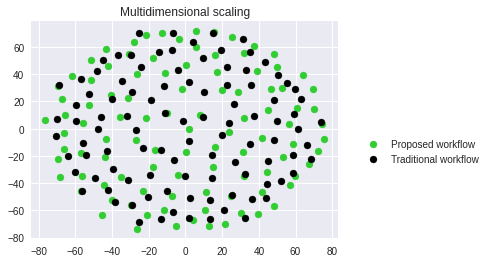

In [3]:
plt.style.use("seaborn")
fig, ax = plt.subplots(1, 1, figsize=(5.5, 4))
plt.scatter(x=gan[:, 0], y=gan[:, 1], color="limegreen")
plt.scatter(x=original[:, 0], y=original[:, 1], color="black")
plt.title("Multidimensional scaling")
plt.legend(["Proposed workflow", "Traditional workflow"],
           bbox_to_anchor = (1.05, 0.5))
plt.savefig("mds.png", dpi=500, bbox_inches='tight')

In [4]:
import os
import pandas as pd
from src.helpers.funcs import *

def calculate_uncertainty(dict_ti: pd.DataFrame):
    _data = dict_ti.copy()

    _data['prob_sand'] = _data.sum(axis=1)
    _data['prob_shale'] = 100 - _data['prob_sand']

    _data["u_max"] = _data[["prob_shale", "prob_sand"]].max(axis=1) / 100
    _data["u_min"] = _data[["prob_shale", "prob_sand"]].min(axis=1) / 100

    _data.drop('prob_sand', axis=1, inplace=True)
    _data.drop('prob_shale', axis=1, inplace=True)

    return _data

def concatenate_out_files(directory: str):
    cat_array = []
    for im in os.listdir(directory):
        image = np.loadtxt(directory+im, skiprows=4)[:,0]
        cat_array.append(np.resize(image, (150, 150)))
    return cat_array

print("[INFO] Loading WGAN simulations", end="\r")
gan_realizations = concatenate_out_files("gan_bin/simulations/")

ti_dict = dict()
for idx, realization in enumerate(gan_realizations):
    ti_dict[f'ti_{idx+1}'] = np.array(realization.reshape(-1))

gan_dataframe = pd.DataFrame(ti_dict)

ti_dict = dict()

print("[INFO] Loading simulations", end="\r")
file = read_conditional_samples("bin/snesim.out")["D"]
realizations = file[:, 0].reshape(100, 150, 150)

for idx, realization in enumerate(realizations):
    ti_dict[f'ti_{idx+1}'] = np.array(realization.reshape(-1))

snesim_dataframe = pd.DataFrame(ti_dict)

eas: file ->      bin/snesim.out
eas: title-> SNESIM Realizations


/home/gustavo/gan-for-mps/.venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/gustavo/gan-for-mps/.venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


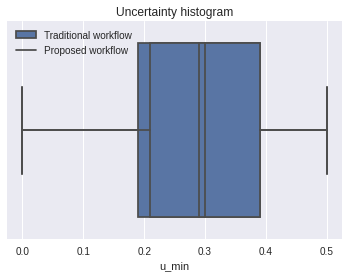

In [10]:
import seaborn as sns

data_snesim = calculate_uncertainty(snesim_dataframe)
data_gan = calculate_uncertainty(gan_dataframe)

sns.boxplot(data_snesim['u_min'], c='black')
sns.boxplot(data_gan['u_min'], c='green')
plt.title("Uncertainty histogram")

plt.legend(["Traditional workflow", "Proposed workflow"])